# Setup

## Imports

In [1]:
# Setup
import os
import joblib
import pickle
import json
from utils.custom_transformers import ColumnSelector, CategoricalTransformer, SaveTransformer, NumericalTransformer

# Data Analysis
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

#Scikit learn
from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,roc_auc_score,roc_curve,classification_report,auc, plot_confusion_matrix


## Configs

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
seed = 42

## Functions

In [3]:
def load_data(file_name, folder = "data"):
    df = pd.read_csv(os.path.join(folder, file_name))
    return df

def target_transformation(text):
    text = text.replace(" ", "").lower()
    if text == "yes" :
        return 1
    elif text == "no":
        return 0

# Data Analysis

## Data Load

In [4]:
df_original = load_data("train_data.csv","data")

## Exploratory Data Analysis

### Overall Analysis

In [ ]:
df_original.dtypes

In [6]:
df_original.isna().sum()

admission_id                      0
patient_id                        0
race                              0
gender                            0
age                            2336
weight                         1560
admission_type_code            1162
discharge_disposition_code      571
admission_source_code             0
time_in_hospital                  0
payer_code                        0
medical_specialty                 0
has_prosthesis                    0
complete_vaccination_status       0
num_lab_procedures             1493
num_procedures                    0
num_medications                2678
number_outpatient                 0
number_emergency                  0
number_inpatient                  0
diag_1                            0
diag_2                         1349
diag_3                            0
number_diagnoses                  0
blood_type                        0
hemoglobin_level                  0
blood_transfusion                 0
max_glu_serum               

In [31]:
df_original['medical_specialty'].value_counts()

?                         40020
InternalMedicine          11712
Emergency/Trauma           6021
Family/GeneralPractice     5939
Cardiology                 4273
                          ...  
Dermatology                   1
Psychiatry-Addictive          1
Speech                        1
Resident                      1
Perinatology                  1
Name: medical_specialty, Length: 71, dtype: int64

# Pipelines

## Custom Transformers

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [6]:
class Save(BaseEstimator, TransformerMixin):
    
    def __init__(self, step):
        self.step = step
        pass
    
    def fit(self, X=None, y=None, **fit_params):
        return self
    
    def transform(self, data):
        X = data.copy()
        name = "pipeline_"+self.step+"_spy.csv"
        pd.DataFrame(X).head(50).to_csv(name)
        return X

In [7]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def pre_process_text(self, obj):
        return str(obj).replace(" ","").lower()
    
    def bool_to_binary(self, obj):
        if obj == True:
            return 1
        elif obj == False:
            return 0
    
    def text_to_binary(self, obj):
        if obj == "yes" or obj == "ch"  :
            return 1
        elif obj == "no":
            return 0
    
    def handle_missing_values(self, obj):
        if pd.isna(obj) or str(obj) == "?" or str(obj) == "unknown/invalid" or str(obj) == "nan" :
            return np.nan
        else :
            return obj
        
    def transform(self, X, y=None):
        _X = X.copy()
        for _col in _X:     
            if _col in ['has_prosthesis','blood_transfusion']:
                _X[_col] = _X[_col].apply(self.bool_to_binary)
            elif _col in ['diuretics','insulin','change','diabetesMed','readmitted']:
                _X[_col] = _X[_col].apply(self.pre_process_text)
                _X[_col] = _X[_col].apply(self.text_to_binary)
            elif _col in ['admission_source_code','discharge_disposition_code','admission_type_code','race','gender','age','weight','payer_code','medical_specialty','complete_vaccination_status','blood_type','max_glu_serum','A1Cresult','diag_1','diag_2','diag_3']:
                _X[_col] = _X[_col].apply(self.pre_process_text)
                _X[_col] = _X[_col].apply(self.handle_missing_values)
            
        return _X

In [8]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self
    
    def missing_to_zero(self, obj):
        if pd.isna(obj):
            return 0
        else :
            return obj
    
    def return_float(self, obj):
        return float(obj)
    
    def return_int(self, obj):
        return int(obj)
        
    def transform(self, X, y=None):
        _X = X.copy()
        for _col in _X:
            if _col in ['num_lab_procedures','num_procedures','num_medications']:
                _X[_col] = _X[_col].apply(self.missing_to_zero)
                _X[_col] = _X[_col].apply(self.return_int)
            elif _col in ['time_in_hospital','number_outpatient','number_emergency','number_inpatient','number_diagnoses']:
                _X[_col] = _X[_col].apply(self.return_int)
            elif _col in ['hemoglobin_level']:
                _X[_col] = _X[_col].apply(self.return_float)
        return _X

In [26]:
df_original_filtered = df_original.copy()
df_original_filtered = df_original_filtered.drop_duplicates(subset=['patient_id'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_original.drop(columns=['readmitted']), 
                                                    df_original['readmitted'],
                                                    shuffle = False,
                                                    test_size=.05, 
                                                    random_state=seed)

In [6]:
y_train = y_train.apply(target_transformation)
y_test = y_test.apply(target_transformation)

In [7]:
categorical = ['admission_source_code','discharge_disposition_code','admission_type_code','medical_specialty','weight','insulin','change','diag_1','A1Cresult','max_glu_serum','diabetesMed','has_prosthesis','blood_transfusion','diuretics','payer_code','complete_vaccination_status','blood_type','age']
numerical = ['num_medications','hemoglobin_level','time_in_hospital','num_lab_procedures','num_procedures','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
#excluding: ,'diag_2','diag_3', 'race', 'gender'
cat_pipe = Pipeline([
    ('selector', ColumnSelector(categorical))
    ,('transformer',CategoricalTransformer())
    ,('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    ,('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('selector', ColumnSelector(numerical))
    ,('transformer',NumericalTransformer())
    ,('imputer', SimpleImputer(strategy='median'))
    ,('scaler', RobustScaler())
])

pre_processor = FeatureUnion([
    ('cat', cat_pipe)
    ,('num', num_pipe)
])

pipeline = Pipeline([
    ('preprocessor', pre_processor)
    ,('model', LogisticRegression(class_weight='balanced' ))
])

pipeline.fit(X_train, y_train)

# Predict training data
y_train_pred = pipeline.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipeline.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")



/Users/tiagosousa/.virtualenvs/capstone-project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Predictions on training data: [0 0 0 ... 0 1 0]
Predictions on test data: [0 1 0 ... 1 0 0]


/Users/tiagosousa/.virtualenvs/capstone-project/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


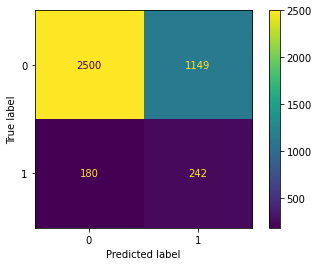

In [8]:
plot_confusion_matrix(pipeline, X_test, y_test)  
plt.show()

ROC-AUC:


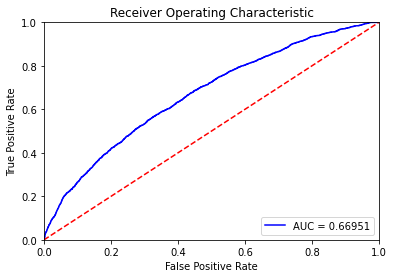

In [15]:
y_scores = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
print("ROC-AUC:")
plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [16]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred)
precision, recall, fscore, support

(array([0.92592827, 0.17678468]),
 array([0.67363092, 0.56533036]),
 array([0.77988226, 0.269343  ]),
 array([21730,  2694]))

In [19]:
for a in np.linspace(0,1,20):
    y_scores_treshold = [1 if x > a else 0 for x in y_scores]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores_treshold, pos_label=1)
    print("With treshold = {} AUC of {}".format(a,auc(fpr, tpr)))

With treshold = 0.0 AUC of 0.5
With treshold = 0.05263157894736842 AUC of 0.5001150483202945
With treshold = 0.10526315789473684 AUC of 0.5006657599458291
With treshold = 0.15789473684210525 AUC of 0.5011949822191839
With treshold = 0.21052631578947367 AUC of 0.5028471170957876
With treshold = 0.2631578947368421 AUC of 0.5109634472610642
With treshold = 0.3157894736842105 AUC of 0.5266996318112107
With treshold = 0.3684210526315789 AUC of 0.5694599237247573
With treshold = 0.42105263157894735 AUC of 0.6088667151116609
With treshold = 0.47368421052631576 AUC of 0.6278367738503623
With treshold = 0.5263157894736842 AUC of 0.6139943512726719
With treshold = 0.5789473684210527 AUC of 0.5979014229777545
With treshold = 0.631578947368421 AUC of 0.5789280161364877
With treshold = 0.6842105263157894 AUC of 0.5620060054027443
With treshold = 0.7368421052631579 AUC of 0.5419162625882677
With treshold = 0.7894736842105263 AUC of 0.5273988044540696
With treshold = 0.8421052631578947 AUC of 0.51803

# Model


In [9]:
TMP_DIR = '/tmp'

In [11]:
with open("columns.json", 'w') as fh:
    json.dump(df_original.columns.tolist(), fh)

with open("dtypes.pickle", 'wb') as fh:
    pickle.dump(df_original.dtypes, fh)
    
joblib.dump(pipeline, 'pipeline.pickle') 

['pipeline.pickle']